# Inspect PhoSim Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa


from astropy.io.fits import getdata
from skimage.morphology import watershed

# Import astro_rcnn
import astro_rcnn
from astro_rcnn import PhoSimDataset

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
#OUT_DIR = os.path.abspath("./phosim_release/output/")
OUT_DIR = os.path.abspath("./validationset/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


%matplotlib inline 

Using TensorFlow backend.


## Configurations

In [2]:
config = astro_rcnn.DESConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     24
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      4
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Dataset

In [3]:
# Load dataset
dataset = PhoSimDataset()
dataset.load_sources(OUT_DIR)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 50
Class Count: 3
  0. BG                                                
  1. star                                              
  2. galaxy                                            


## Display Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


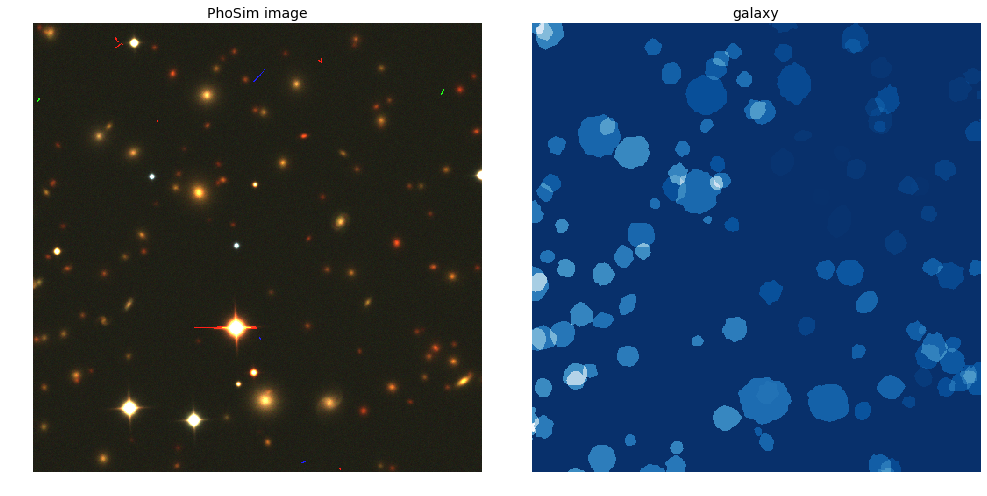

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (512, 512, 3)         min:   10.00000  max: 65534.00000  uint32
mask                     shape: (512, 512, 131)       min:    0.00000  max:    1.00000  bool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


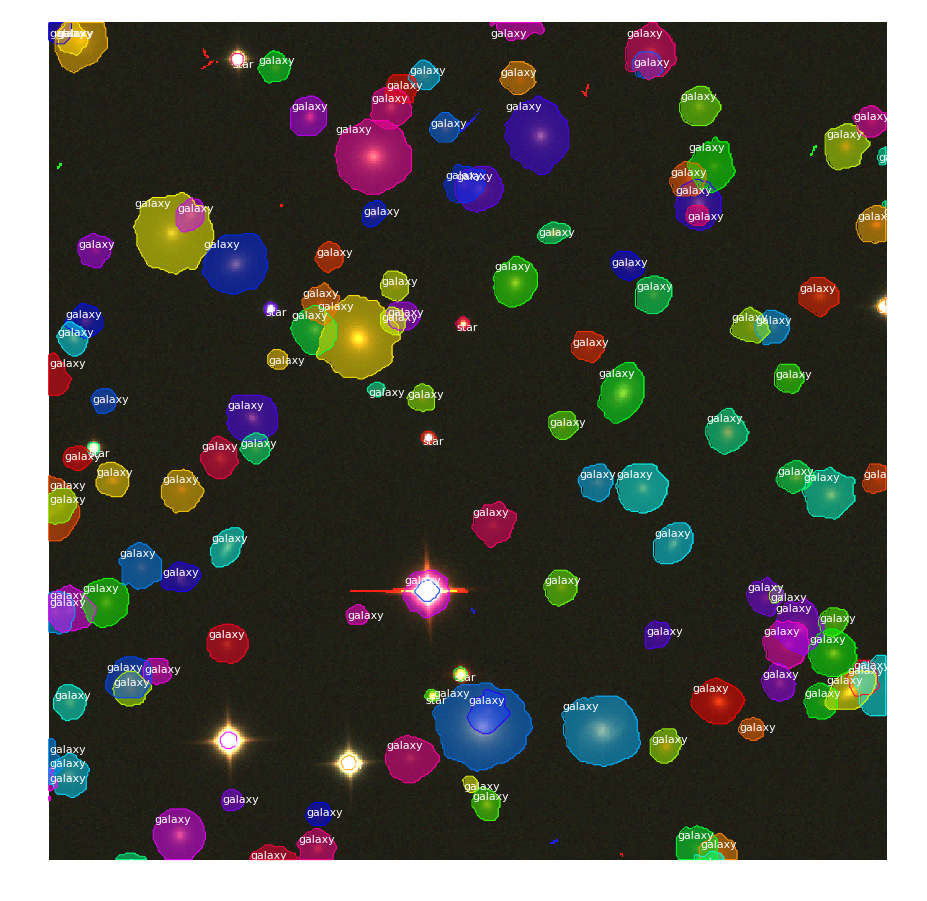

In [5]:
# Map source ID to Dataset image_id

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## Image Augmentation

Test out different augmentation methods

In [ ]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

In [ ]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Count:  65472
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192
Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


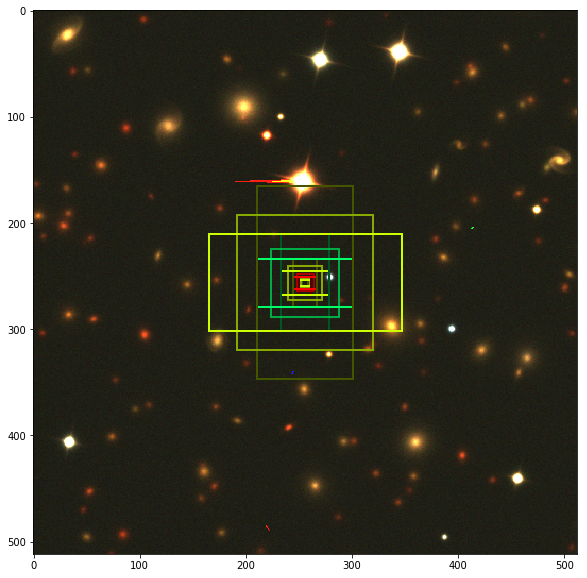

In [6]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)

### Write out Anchor / ROI values into new file
#f = open("anchor_ROI_tests/param_train_ROIS_250_final.txt", "w+")
#f.write("Count: %g \n" % (anchors.shape[0]))
#f.write("Scales: %g %g %g %g %g \n" % (config.RPN_ANCHOR_SCALES)) 
#f.write("ratios: [%g, %g, %g] \n" % (config.RPN_ANCHOR_RATIOS[0], config.RPN_ANCHOR_RATIOS[1],
                                    #config.RPN_ANCHOR_RATIOS[2]))
#f.writelines(["ratios: %s\n" % item for item in config.RPN_ANCHOR_RATIOS])
#f.write("Anchors per Cell: %g \n" % (anchors_per_cell))
#f.write("Levels: %g \n" % (num_levels))

anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))
    #f.write("Anchors in Level %g: %g \n" % (l, anchors_per_level[l]))
    
# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    #f.write("Level %g. Anchors: %g Feature map Shape: [%g %g] \n" % (level, level_anchors.shape[0], 
                                                                     #backbone_shapes[level][0], backbone_shapes[level][1]))
    #f.writelines(["Feature map Shape: %s\n" % x for x in backbone_shapes[level][0]])
    #f.write("Feature map Shape: [%g %g] \n" % (backbone_shapes[level][0], backbone_shapes[level][1]))

    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)



## Data Generator

In [7]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [8]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 250, 4)           min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 250, 1)           min:    0.00000  max:    2.00000  int32
mrcnn_bbox               shape: (4, 250, 3, 4)        min:   -3.43750  max:    4.00000  float32
mrcnn_mask               shape: (4, 250, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    1.00000  max:    2.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  512.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 512, 4)           min:   -6.93147  max:    3.76019  float64
image_id:  21 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


anchors                  shape: (65472, 4)            min:  -90.50967  max:  538.50967  float64
refined_anchors          shape: (153, 4)              min:   -0.00000  max:  512.00000  float32
Positive anchors: 153
Negative anchors: 359
Neutral anchors: 64960
BG                     : 215
star                   : 3
galaxy                 : 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


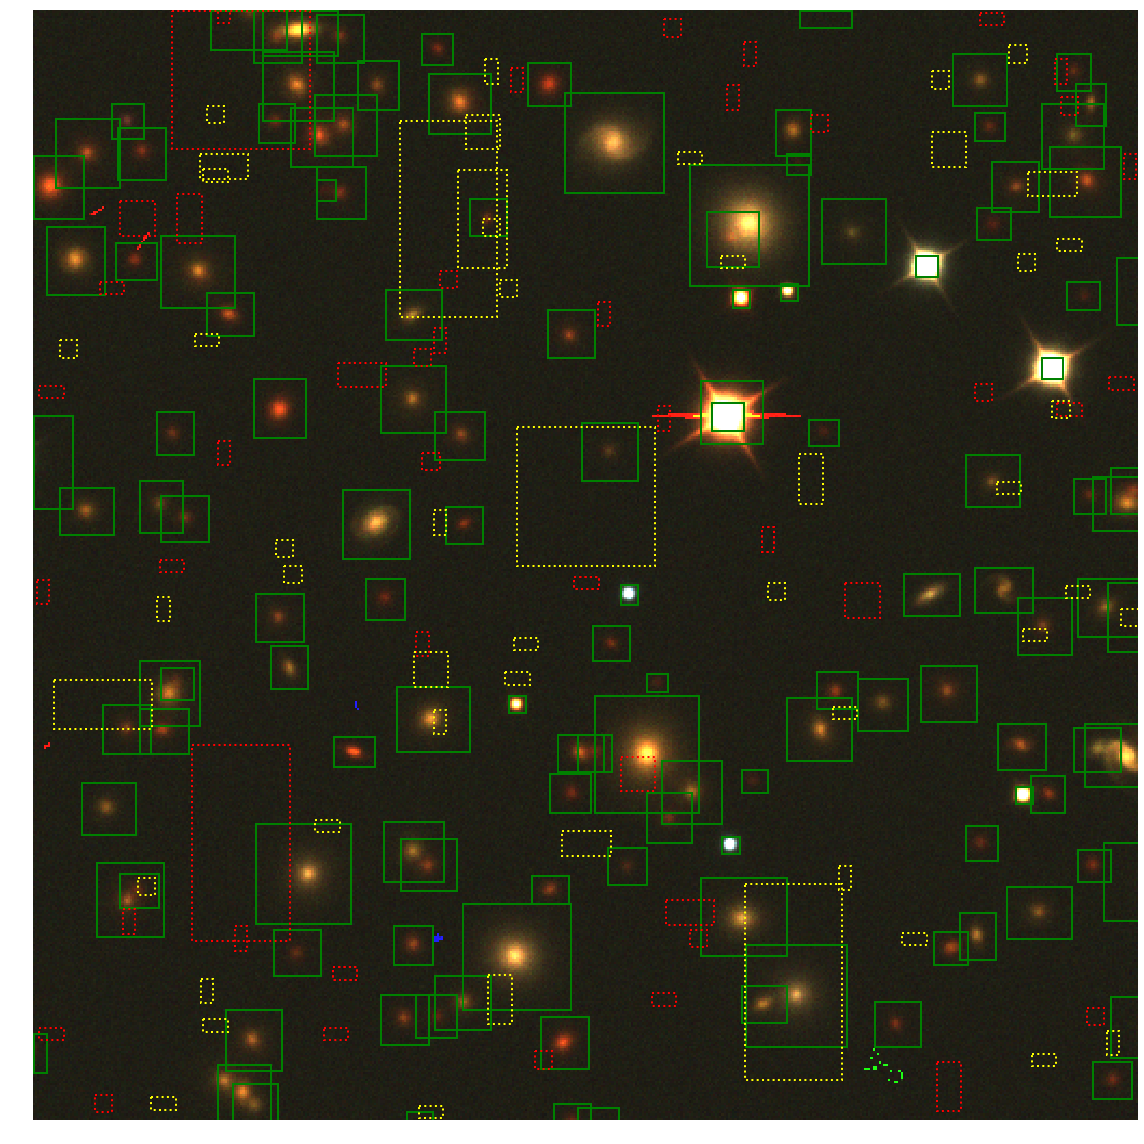

In [9]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

#f = open("anchor_ROI_tests/param_train_ROIS_250_final.txt", "a+")
#f.write("Positive anchors: %g \n" % len(positive_anchor_ids))
#f.write("Negative anchors: %g \n" % len(negative_anchor_ids))
#f.write("Neutral anchors: %g \n" % len(neutral_anchor_ids))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))
        #f.write("%s %g \n" % (c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, set_color=1, 
                     refined_boxes=refined_anchors, ax=ax)
visualize.draw_boxes(sample_image, set_color=2, boxes=anchors[np.random.choice(negative_anchor_ids, 50)], 
                     ax=ax)
visualize.draw_boxes(sample_image, set_color=3, boxes=anchors[np.random.choice(neutral_anchor_ids, 50)], 
                     ax=ax)
plt.tight_layout()

plt.savefig("./roi.eps",fmt="eps")

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

In [14]:
if random_rois:
    # Display ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

NameError: name 'refined_rois' is not defined

In [10]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
        
        #f = open("anchor_ROI_tests/param_train_ROIS_250_final.txt", "a+")
        #f.write("%g %g \n"% (positive_rois, positive_rois/ids.shape[1]))
        
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))
    #f.write("Average percent: %g \n" % (total/(limit*ids.shape[1])))

   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
   82  0.33
Average percent: 0.33
